In [14]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# Load preprocessed data
combined_y1 = pd.read_csv("../data/preprocessed/prp_combined_Y1.csv")
combined_y2 = pd.read_csv("../data/preprocessed/prp_combined_Y2.csv")

# Confirm the shapes of the datasets
print(f"Combined Y1 shape: {combined_y1.shape}")
print(f"Combined Y2 shape: {combined_y2.shape}")

Combined Y1 shape: (75996, 18)
Combined Y2 shape: (71400, 18)


In [4]:
# Define the features (X) and target (y)
# We drop the 'MemberID' and target column ('DaysInHospitalY2' or 'DaysInHospitalY3')

# Training data
X_train = combined_y1.drop(columns=['MemberID', 'DaysInHospitalY2'])
y_train = combined_y1['DaysInHospitalY2']

# Testing data
X_test = combined_y2.drop(columns=['MemberID', 'DaysInHospitalY3'])
y_test = combined_y2['DaysInHospitalY3']

# Confirm shapes
print(f"Training Features shape: {X_train.shape}")
print(f"Training Target shape: {y_train.shape}")
print(f"Testing Features shape: {X_test.shape}")
print(f"Testing Target shape: {y_test.shape}")

Training Features shape: (75996, 16)
Training Target shape: (75996,)
Testing Features shape: (71400, 16)
Testing Target shape: (71400,)


**Basic XGBoost Model Training and Evaluation**

Trained a basic XGBoost model using the default parameters without any hyperparameter tuning. The key steps are:

- **Model Definition**:
  - The model is defined with default parameters using ``XGBClassifier``.
  - The evaluation metric is set to ``logloss`` to guide the model optimization.

- **Training**:
  - The model was trained on the preprocessed training dataset (`X_train` and `y_train`).

- **Prediction and Evaluation**:
  - Predictions were made on the test dataset (`X_test`) to evaluate the model's generalizability.
  - The following metrics were used for evaluation:
    - **ROC-AUC**: Evaluates the ability of the model to distinguish between classes. If multiclass, the ``ovr`` (one-vs-rest) method was used.
    - **Precision**: Evaluates the accuracy of the positive predictions, with ``average='macro'`` used for multiclass classification.
    - **Recall**: Measures how well the model captures all positive instances.

This base model serves as a benchmark to compare with more advanced versions that use hyperparameter tuning to improve performance.

In [6]:
# Define the XGBoost model with default parameters
xgb_base_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)

# Train the model on the training data
xgb_base_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_probs = xgb_base_model.predict_proba(X_test)  # Get the predicted probabilities
y_pred = xgb_base_model.predict(X_test)  # Get the predicted class labels

# Calculate the evaluation metrics
if len(np.unique(y_train)) > 2:  # Multiclass case
    roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
    precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=1)
else:  # Binary case
    roc_auc = roc_auc_score(y_test, y_pred_probs[:, 1])
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred, zero_division=1)

# Print the evaluation results
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

ROC-AUC Score: 0.6816
Precision: 0.2820
Recall: 0.0637


**Nested Cross-Validation for XGBoost with Basic Hyperparameter Tuning**

Implemented a nested cross-validation strategy to evaluate and tune the XGBoost model. The nested cross-validation setup includes:

- **Outer Cross-Validation Loop**: 
  - Used **20-fold cross-validation** to assess the generalizability and performance of the final model.
  - This helps ensure robustness by testing the model across different subsets of the data.

- **Inner Cross-Validation Loop**:
  - Used **4-fold cross-validation** for hyperparameter tuning.
  - A parameter grid was defined for tuning the following XGBoost hyperparameters:
    - ``learning_rate``: Controls the step size at each iteration, with values `[0.01, 0.05, 0.1, 0.2]`.
    - ``max_depth``: Maximum depth of the trees, with values `[3, 5, 7, 10]`.
    - ``n_estimators``: Number of boosting rounds, with values `[50, 100, 200, 300]`.
    - ``subsample``: Fraction of samples to be used for fitting individual trees, with values `[0.8, 0.9, 1.0]`.
  - **RandomizedSearchCV** was used to find the best hyperparameter combination, with ``n_iter`` set to 10.

- **Metrics Used for Evaluation**:
  - **ROC-AUC**: Evaluates the quality of the model's ability to distinguish between classes.
  - **Precision**: Assesses the accuracy of positive predictions.
  - **Recall**: Measures how well the model captures all positive instances.

- **Model Training and Evaluation**:
  - Hyperparameter tuning was performed on the training set for each fold of the outer loop.
  - The best model was evaluated on the test set from the outer cross-validation loop.
  
This approach ensures that the model is not overfitted to the training data, as hyperparameter tuning is separated from model evaluation.

In [7]:
# Set up nested cross-validation strategy
outer_cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)  # 20-fold CV for the outer loop
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)  # 4-fold CV for the inner loop

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.8, 0.9, 1.0]
}

# Define the XGBoost classifier
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='roc_auc',
    cv=inner_cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Cross-validation scoring metrics
scorers = {
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score, zero_division=1),
    'recall': make_scorer(recall_score, zero_division=1)
}

# Set up empty lists to store scores
outer_scores = []

# Loop for the outer cross-validation
for train_idx, test_idx in outer_cv.split(X_train, y_train):
    # Split the data into training and validation sets for the outer loop
    X_outer_train, X_outer_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_outer_train, y_outer_test = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    # Perform hyperparameter tuning using inner cross-validation
    random_search.fit(X_outer_train, y_outer_train)
    
    # Best estimator from inner cross-validation
    best_model = random_search.best_estimator_
    
    # Evaluate the model on the outer test fold
    y_pred_probs = best_model.predict_proba(X_outer_test)  # Get the predicted probabilities
    y_pred = best_model.predict(X_outer_test)  # Get the predicted class labels

    # Ensure y_pred and y_outer_test are one-dimensional
    y_pred = y_pred.ravel() if len(y_pred.shape) > 1 else y_pred
    y_outer_test = y_outer_test.ravel() if len(y_outer_test.shape) > 1 else y_outer_test

    # Calculate metrics based on the test set
    if len(np.unique(y_outer_train)) > 2:  # Multiclass case
        roc_auc = roc_auc_score(y_outer_test, y_pred_probs, multi_class='ovr')
        precision = precision_score(y_outer_test, y_pred, average='macro', zero_division=1)
        recall = recall_score(y_outer_test, y_pred, average='macro', zero_division=1)
    else:  # Binary case
        roc_auc = roc_auc_score(y_outer_test, y_pred_probs[:, 1])  # For binary classification, take the second column
        precision = precision_score(y_outer_test, y_pred, zero_division=1)
        recall = recall_score(y_outer_test, y_pred, zero_division=1)
    
    # Store the scores
    outer_scores.append({'roc_auc': roc_auc, 'precision': precision, 'recall': recall})

# Convert the scores list into a DataFrame to analyze the results
results_df = pd.DataFrame(outer_scores)
print("Mean ROC-AUC:", results_df['roc_auc'].mean())
print("Mean Precision:", results_df['precision'].mean())
print("Mean Recall:", results_df['recall'].mean())

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each

**Expanded Hyperparameter Tuning with Nested Cross-Validation**

Performed an expanded hyperparameter tuning for the XGBoost model using nested cross-validation, building on the previous approach. The key changes made in this version compared to the previous model are:

- **Parameter Grid Expansion**: 
  - The parameter grid now includes additional hyperparameters, such as:
    - ``colsample_bytree``: Controls the fraction of features to be randomly sampled for each tree, which helps reduce overfitting.
    - ``min_child_weight``: Specifies the minimum sum of instance weight (hessian) needed in a child node, helping to control model complexity.
    - ``scale_pos_weight``: Helps in handling class imbalance by adjusting the balance of positive and negative classes.
  - Increased granularity of ``learning_rate``, ``max_depth``, and ``n_estimators`` to more thoroughly explore the parameter space.

- **Increased Number of Iterations**: 
  - The ``n_iter`` parameter in ``RandomizedSearchCV`` was increased from 10 to 20, allowing for a more comprehensive search of hyperparameter combinations, thus increasing the likelihood of finding an optimal set of values.

- **Evaluation Metrics**: 
  - The same metrics—**ROC-AUC**, **Precision**, and **Recall**—are used to evaluate model performance, but the expanded parameter grid is expected to improve these scores compared to the previous run.

These changes are intended to help achieve better model performance, improving generalizability by balancing complexity and fit while mitigating overfitting risks.

In [8]:
# Define the parameter grid for RandomizedSearchCV with additional hyperparameters
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10, 15],
    'n_estimators': [50, 100, 200, 300, 500],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'scale_pos_weight': [1, 2, 5, 10]  # Adjust for class imbalance
}

# Set up RandomizedSearchCV with more iterations to better explore the parameter space
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,  # Increased from 10 to 20 to explore more combinations
    scoring='roc_auc',
    cv=inner_cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Loop for the outer cross-validation
outer_scores = []  # Reset the outer scores list
for train_idx, test_idx in outer_cv.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    # Perform hyperparameter tuning using inner cross-validation
    random_search.fit(X_tr, y_tr)
    
    # Best estimator from inner cross-validation
    best_model = random_search.best_estimator_
    
    # Evaluate the model on the validation fold
    y_pred_probs = best_model.predict_proba(X_val)
    y_pred = best_model.predict(X_val)

    # Ensure y_pred and y_val are one-dimensional
    y_pred = y_pred.ravel() if len(y_pred.shape) > 1 else y_pred
    y_val = y_val.ravel() if len(y_val.shape) > 1 else y_val

    # Evaluate the model on the outer test fold
    if len(np.unique(y_val)) > 2:
        roc_auc = roc_auc_score(y_val, y_pred_probs, multi_class='ovr')
        precision = precision_score(y_val, y_pred, average='macro', zero_division=1)
        recall = recall_score(y_val, y_pred, average='macro', zero_division=1)
    else:
        roc_auc = roc_auc_score(y_val, y_pred_probs[:, 1])  # For binary classification, take the second column
        precision = precision_score(y_val, y_pred, average='binary', zero_division=1)
        recall = recall_score(y_val, y_pred, average='binary', zero_division=1)
    
    # Store the scores
    outer_scores.append({'roc_auc': roc_auc, 'precision': precision, 'recall': recall})

# Convert the scores list into a DataFrame to analyze the results
results_df = pd.DataFrame(outer_scores)
print("Mean ROC-AUC:", results_df['roc_auc'].mean())
print("Mean Precision:", results_df['precision'].mean())
print("Mean Recall:", results_df['recall'].mean())

Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Fitting 4 folds for each

**ROC Curve for the Best Model**

This plot visualizes the performance of the final XGBoost model using the Receiver Operating Characteristic (ROC) curve, which shows the trade-off between True Positive Rate (Sensitivity) and False Positive Rate (1 - Specificity) across different thresholds.

A higher area under the ROC curve indicates a better-performing model.

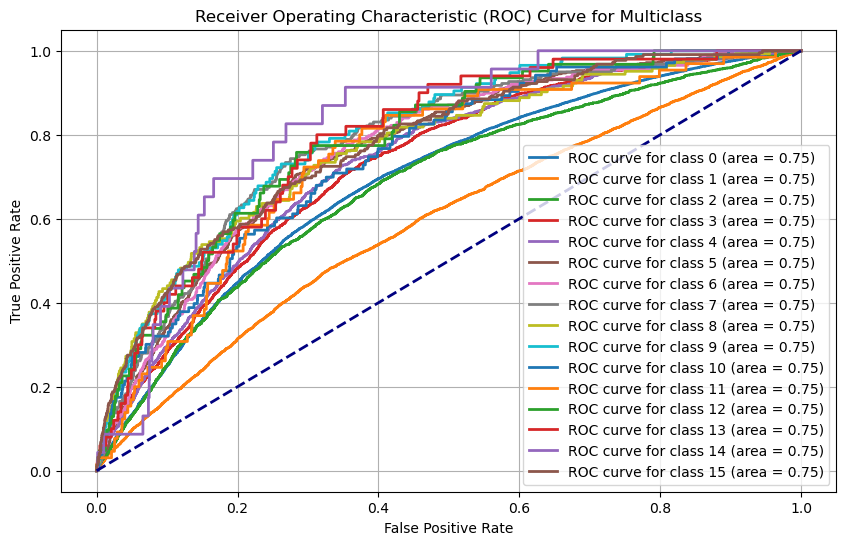

In [16]:
# Assuming your target variable y_test contains multiple classes, binarize it
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_pred_probs = best_model.predict_proba(X_test)

# Compute ROC AUC for multiclass
roc_auc = roc_auc_score(y_test_bin, y_pred_probs, average="macro", multi_class="ovr")

# Plotting the ROC curve for each class
plt.figure(figsize=(10, 6))

for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve for class {class_label} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc='lower right')
plt.grid()
plt.show()

**Precision-Recall Curve for the Best Model**

This curve helps us understand the model's performance in terms of precision and recall across various thresholds. It is particularly useful when the dataset is imbalanced, as it focuses on the positive (minority) class.

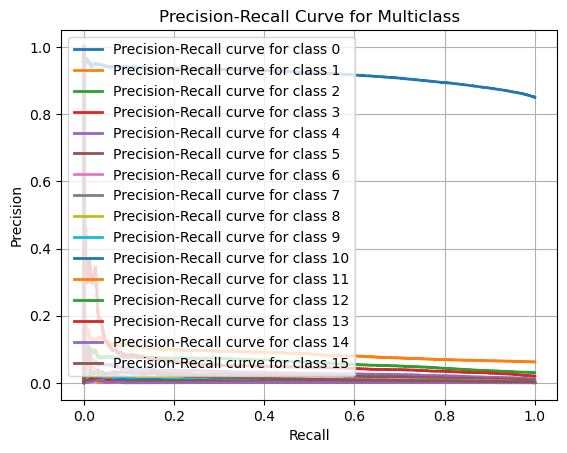

In [18]:
# Binarize the output
n_classes = len(np.unique(y_test))
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Compute precision-recall curve for each class
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f'Precision-Recall curve for class {i}')

# Plotting the precision-recall curve
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiclass')
plt.legend(loc='best')
plt.grid()
plt.show()